In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
import pandas as pd
from itertools import product

# IIR的传递函数
def H_IIR(b, a, w):
    z_1 = np.exp(-1j * w)
    return (b[0] + b[1] * z_1 + b[2] * z_1**2) / (a[0] + a[1] * z_1 + a[2] * z_1**2)
    
# 一阶EMA滤波器的传递函数
def H_ema(alpha, w):
    p = 1.0 - alpha
    # return alpha / (1.0 - p * np.exp(-1j * w))
    return (0.5*alpha + 0.5*alpha*np.exp(-1j * w))/ (1.0 - p * np.exp(-1j * w))

def mag_db(x):
    mag = np.abs(x)
    mag[mag == 0] = np.finfo(float).tiny
    return 20.0 * np.log10(mag)

def cutoff_fc_over_fs(alpha1, alpha2, N):
    """
    Return fc/fs where |H1*H2| hits -3 dB for the first time (from DC upward).
    If no crossing found on [0, fs/2], returns np.nan.
    """
    # w in [0, pi], f_norm = w / (2*pi) in [0, 0.5]
    w = np.linspace(0.0, math.pi, N)
    f_norm = w / (2.0 * math.pi)

    H_tot = H_ema(alpha1, w) * H_ema(alpha2, w)
    mdB = mag_db(H_tot)

    target = -3.0
    mask = (mdB <= target)
    if not np.any(mask):
        return np.nan

    idx = np.argmax(mask)  # first True index
    if idx == 0:
        return f_norm[0]

    # Linear interpolation around the crossing
    x0, x1 = f_norm[idx - 1], f_norm[idx]
    y0, y1 = mdB[idx - 1], mdB[idx]
    if y1 == y0:
        return x1
    frac = (target - y0) / (y1 - y0)
    return x0 + frac * (x1 - x0)


In [2]:
# 绘制出级联ema的fc/fs
# n1 n2的范围
N_MIN, N_MAX = 0, 6

# Frequency grid resolution (bigger -> finer interpolation accuracy)
N_FREQ = 131072

n_values = list(range(N_MIN, N_MAX + 1))
records = []

for n1 in n_values:
        for n2 in n_values:
            a1 = 0.5 ** n1
            a2 = 0.5 ** n2
            fc_over_fs = cutoff_fc_over_fs(a1, a2, N_FREQ)
            records.append({
                "n1": n1,
                "n2": n2,
                "fc_over_fs": fc_over_fs
            })

# 保存为字典
DECIMALS = 6  # 小数位数

fc_fs_dict = {
    (r['n1'], r['n2']): round(float(r['fc_over_fs']), DECIMALS)
    for r in records
    if r['fc_over_fs'] is not None
}

# 可视化fc/fs
df = pd.DataFrame.from_records(records)
pivot = df.pivot(index="n1", columns="n2", values="fc_over_fs").sort_index().sort_index(axis=1)

# 打印纯数字表格（行: n1，列: n2）
print(pivot.to_string(float_format=lambda x: f"{x:.{DECIMALS}f}"))

# 去重与排序
# unique_fc = sorted(df["fc_over_fs"].dropna().unique())
# print("\nUnique fc/fs values:")
# for val in unique_fc:
#     print(f"{val:.{DECIMALS}f}")


n2        0        1        2        3        4        5        6
n1                                                               
0  0.181735 0.093703 0.044199 0.021047 0.010230 0.005039 0.002500
1  0.093703 0.067136 0.039256 0.020372 0.010147 0.005029 0.002499
2  0.044199 0.039256 0.029125 0.018032 0.009776 0.004980 0.002493
3  0.021047 0.020372 0.018032 0.013622 0.008654 0.004789 0.002467
4  0.010230 0.010147 0.009776 0.008654 0.006594 0.004241 0.002370
5  0.005039 0.005029 0.004980 0.004789 0.004241 0.003245 0.002099
6  0.002500 0.002499 0.002493 0.002467 0.002370 0.002099 0.001610


In [3]:
# 根据我们的cic的osr，avf的dec与odr要求，计算需要的fc/fs
# gyro
source_clk = 3.2768e6  # Hz rtl is 3.125e6?
cic_osr = [32, 64, 128, 256, 512]
notch_dec = [32, 64, 128]
lpf_fs = sorted(set([round(source_clk/osr/dec) for osr, dec in product(cic_osr, notch_dec)]))
# print(lpf_fs)
# lpf_fs = [50, 100, 200, 400, 800, 1600, 3200]

# st_odr =    [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]# Hz
# st_fc_odr = [11, 20, 39,  77,  152, 300, 557,  751,  712]

needed_fc_over_fs = [fc/odr for odr in lpf_fs for fc in [11, 20, 39, 77, 152, 300, 557, 751, 712] if fc < 0.25*odr]
needed_fc_over_fs = sorted(set(needed_fc_over_fs), reverse=True)
print("\nNeeded fc/fs values: range from {:.6f} to {:.6f}".format(min(needed_fc_over_fs), max(needed_fc_over_fs)))


Needed fc/fs values: range from 0.003438 to 0.234687


In [4]:
# 根据我们的cic的osr，avf的dec与odr要求，计算需要的fc/fs
# gyro
source_clk = 3.2768e6  # Hz rtl is 3.125e6?
cic_osr = [32, 64, 128, 256, 512]
notch_dec = [32, 64, 128]
lpf_fs = sorted(set([round(source_clk/osr/dec) for osr, dec in product(cic_osr, notch_dec)]))
print(lpf_fs)
# lpf_fs = [50, 100, 200, 400, 800, 1600, 3200]

# st_odr =    [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]# Hz
# st_fc_odr = [11, 20, 39,  77,  152, 300, 557,  751,  712]

needed_fc_over_fs = [fc/odr for odr in lpf_fs for fc in [11, 20, 39, 77, 152, 300, 557, 751, 712] if fc < 0.25*odr]
needed_fc_over_fs = sorted(set(needed_fc_over_fs), reverse=True)
print("\nNeeded fc/fs values: range from {:.6f} to {:.6f}".format(min(needed_fc_over_fs), max(needed_fc_over_fs)))


[50, 100, 200, 400, 800, 1600, 3200]

Needed fc/fs values: range from 0.003438 to 0.234687


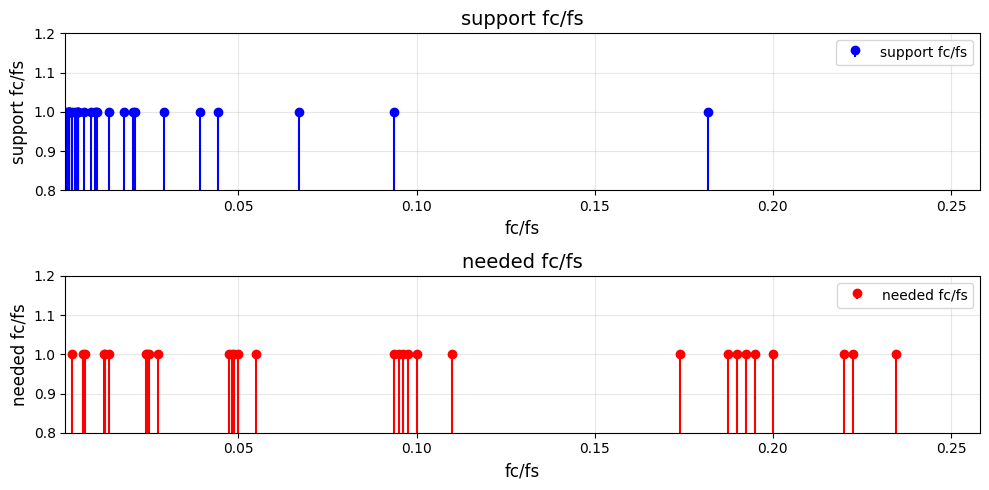

In [5]:
# 比较我们支持的fc/fs与需要的fc/fs
supported_fc_over_fs = sorted(set(df['fc_over_fs'].dropna()), reverse=True)

# 需要的fc/fs（你的代码）
needed_fc_over_fs = [fc/odr for odr in lpf_fs for fc in [11, 20, 39, 77, 152, 300, 557, 751, 712] if fc < 0.25*odr]
needed_fc_over_fs = sorted(set(needed_fc_over_fs), reverse=True)

# 创建图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# 设置相同的x轴范围
x_min = min(min(supported_fc_over_fs), min(needed_fc_over_fs)) * 0.9
x_max = max(max(supported_fc_over_fs), max(needed_fc_over_fs)) * 1.1

# 图表1：支持的fc/fs范围
ax1.stem(supported_fc_over_fs, [1]*len(supported_fc_over_fs), 
         linefmt='b-', markerfmt='bo', basefmt=' ', label='support fc/fs')
ax1.set_ylabel('support fc/fs', fontsize=12)
ax1.set_xlabel('fc/fs', fontsize=12)
ax1.set_title('support fc/fs', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.8, 1.2)
ax1.legend()
ax1.tick_params(axis='x', bottom=True, labelbottom=True)

# 图表2：需要的fc/fs范围
ax2.stem(needed_fc_over_fs, [1]*len(needed_fc_over_fs), 
         linefmt='r-', markerfmt='ro', basefmt=' ', label='needed fc/fs')
ax2.set_ylabel('needed fc/fs', fontsize=12)
ax2.set_xlabel('fc/fs', fontsize=12)
ax2.set_title('needed fc/fs', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.8, 1.2)
ax2.legend()

# 设置相同的x轴范围
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2372018/2230284110.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


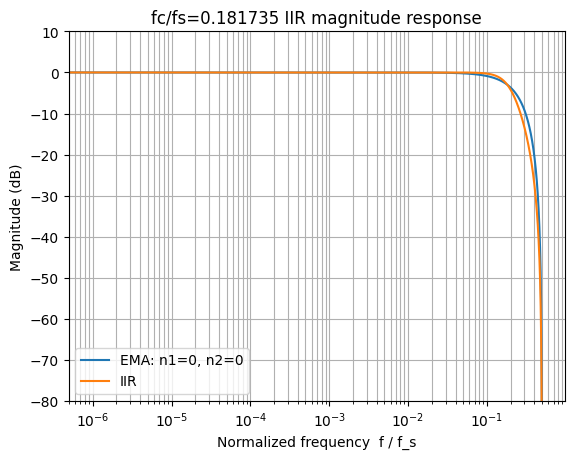

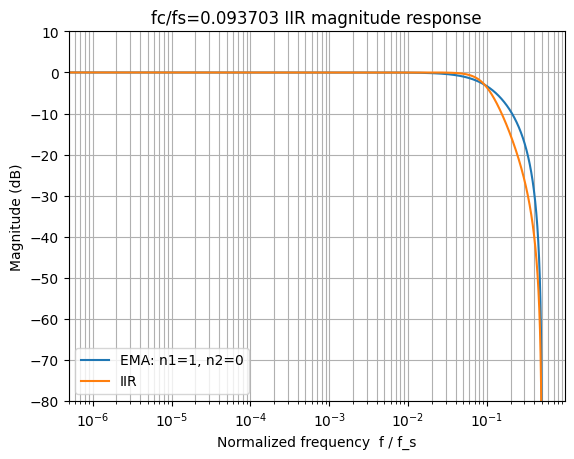

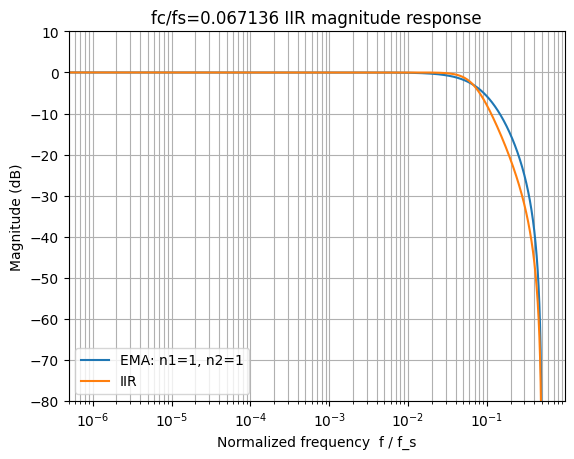

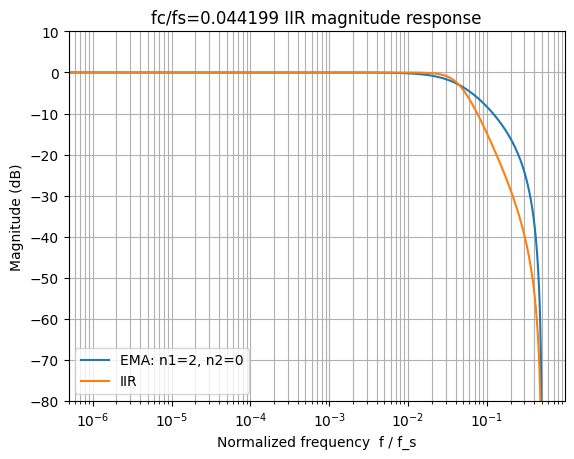

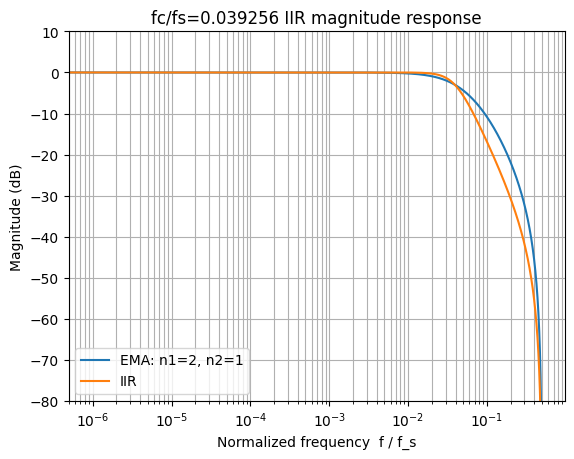

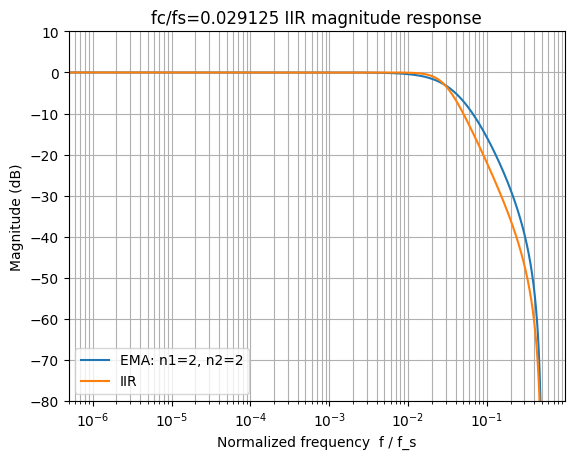

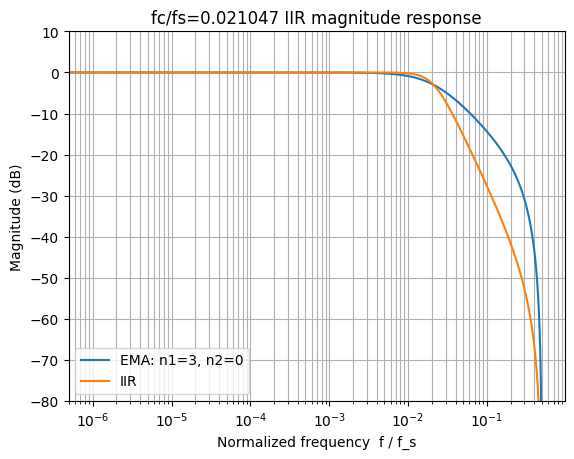

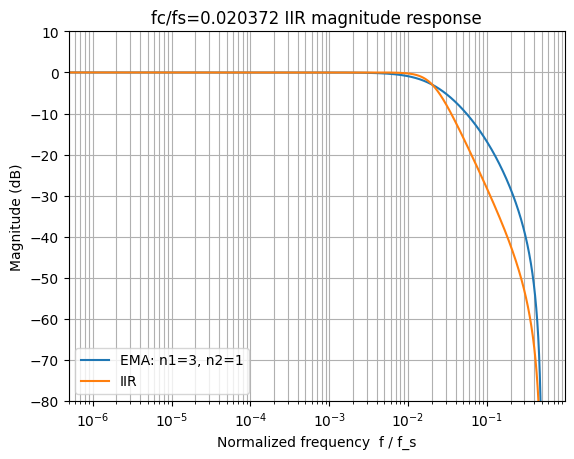

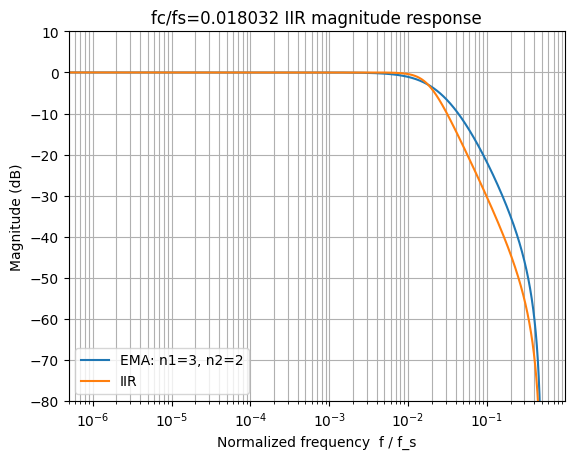

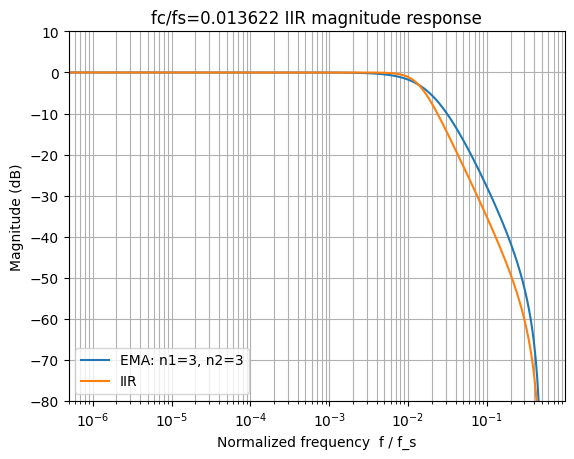

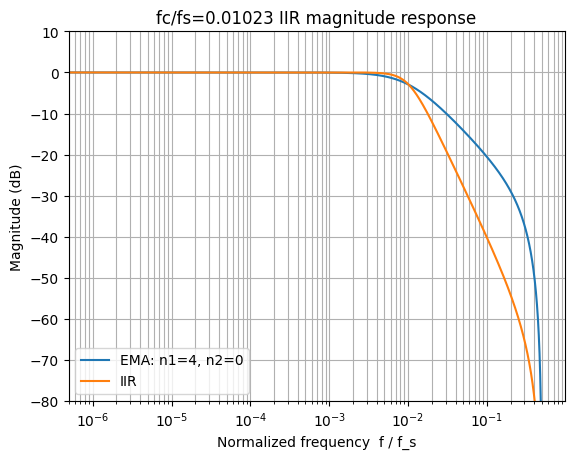

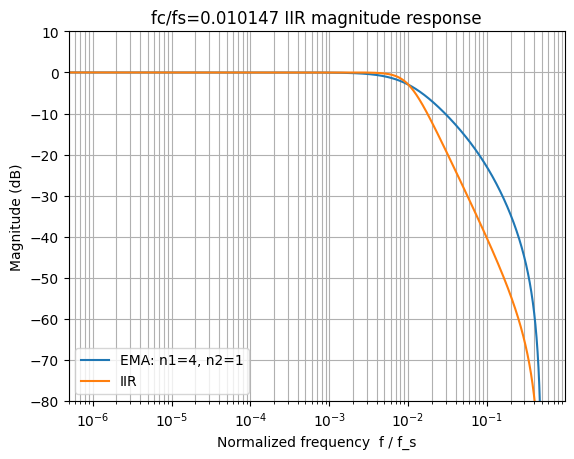

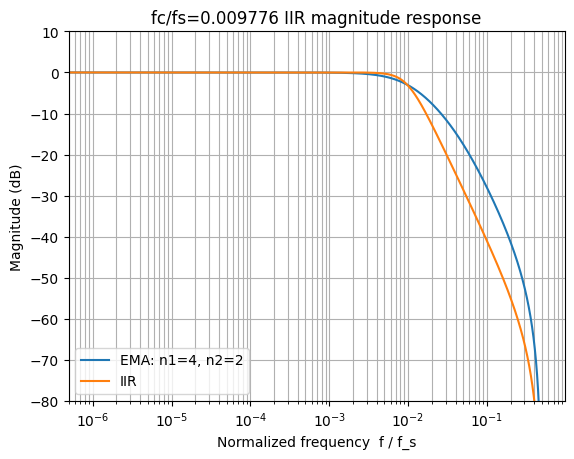

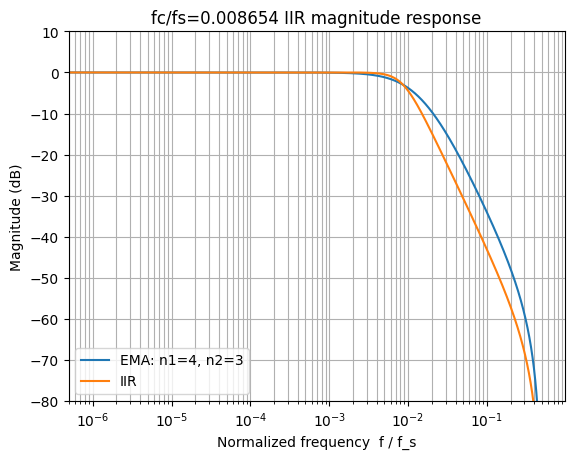

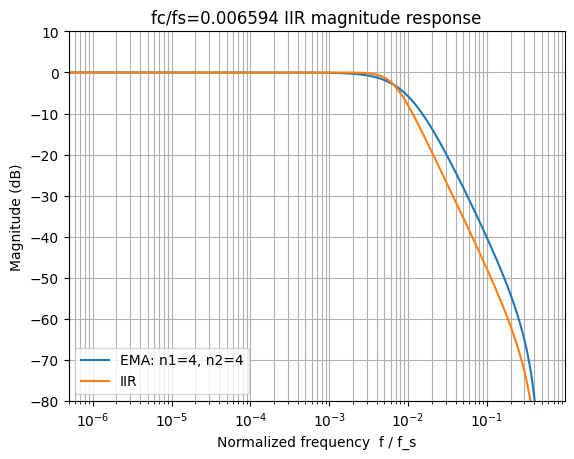

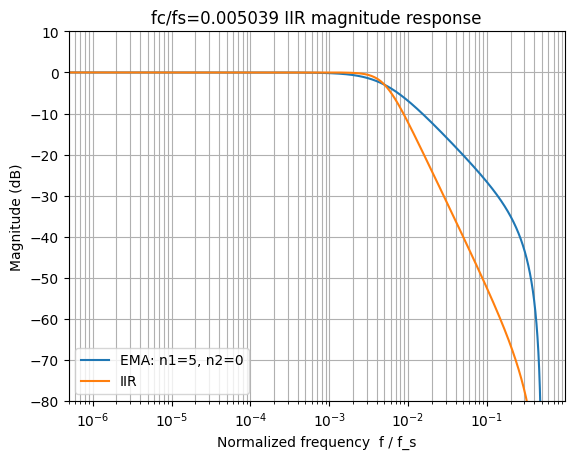

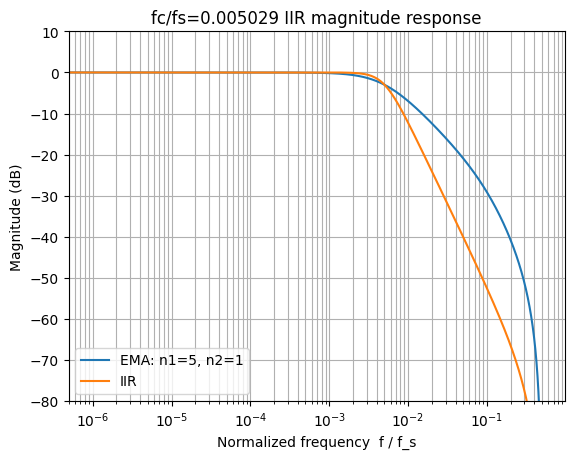

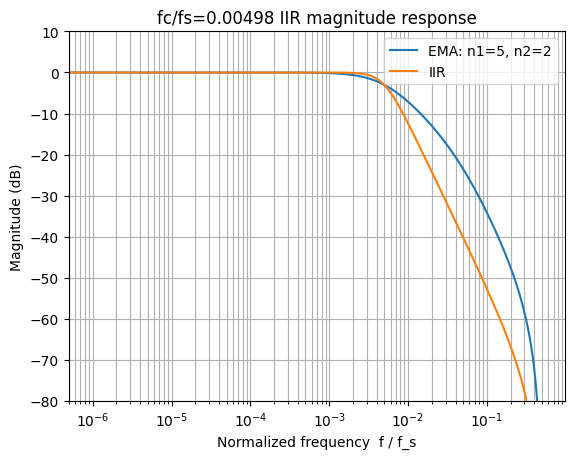

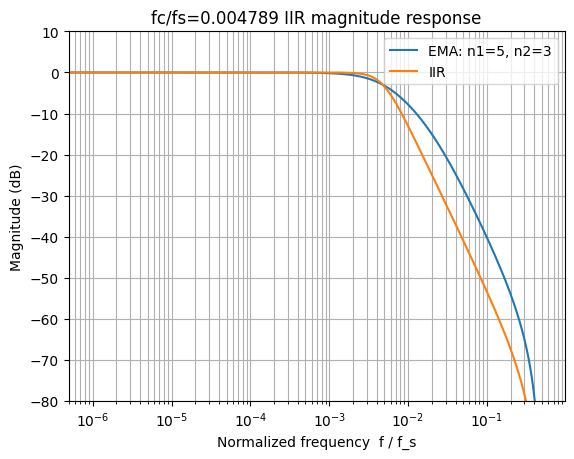

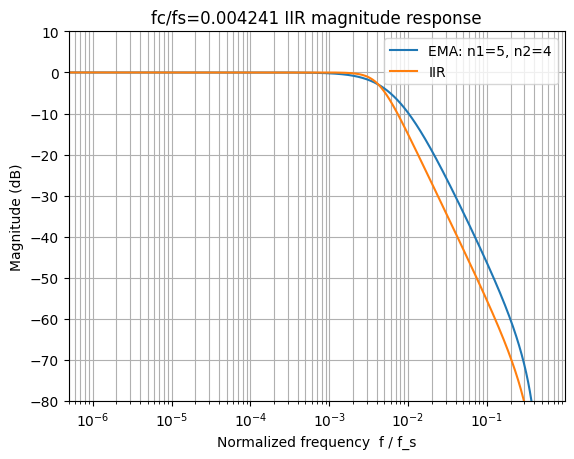

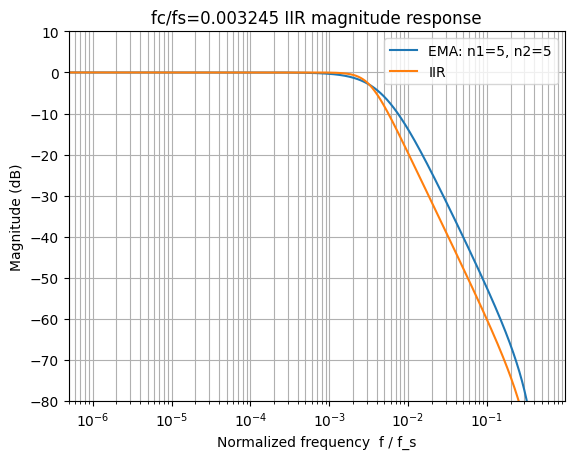

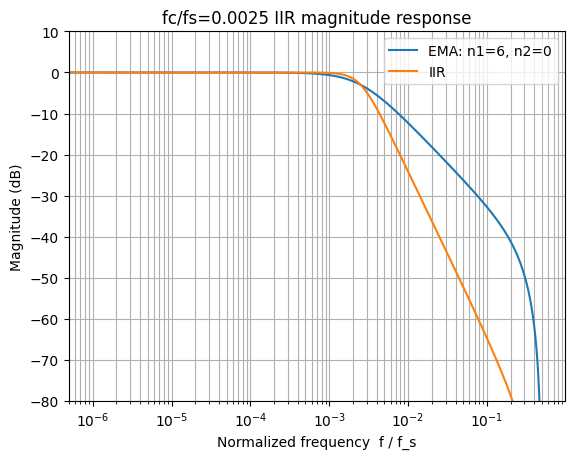

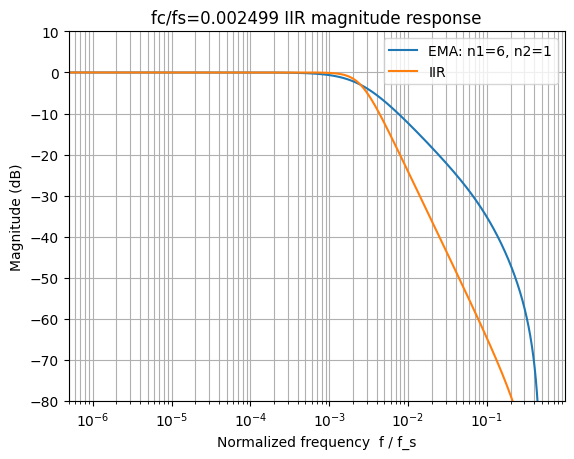

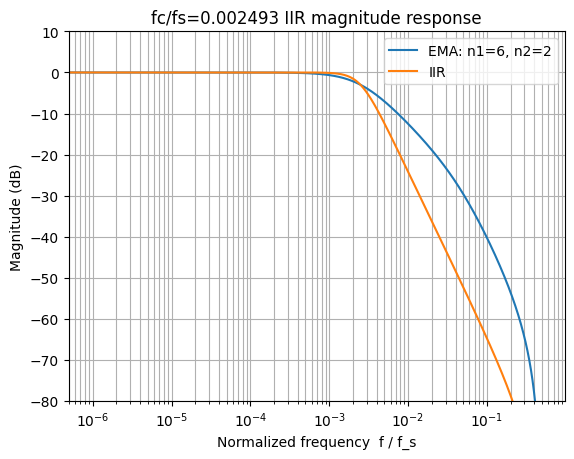

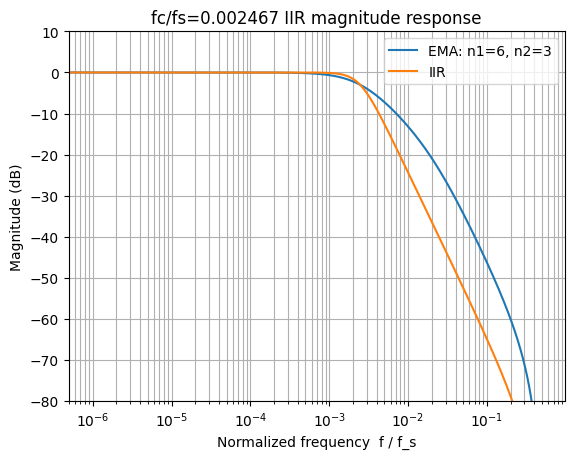

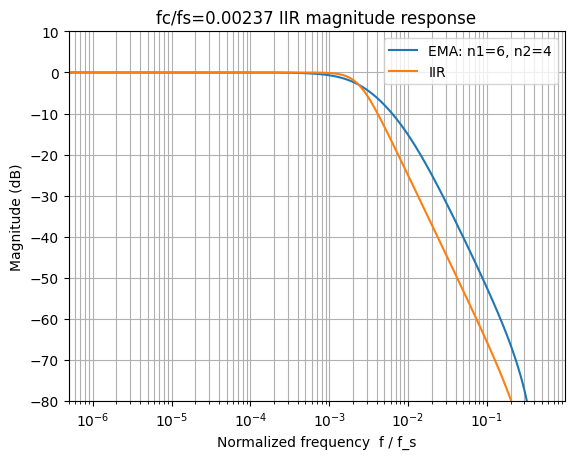

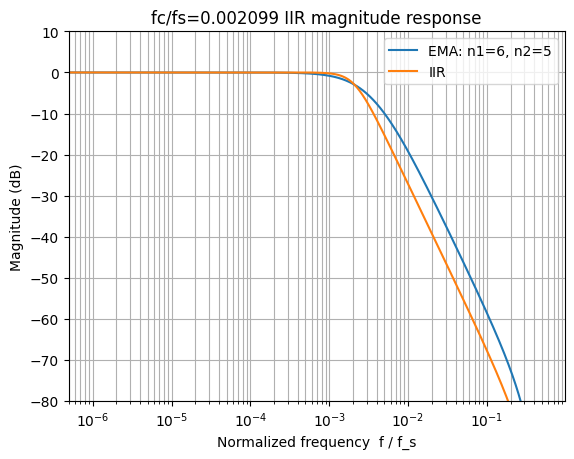

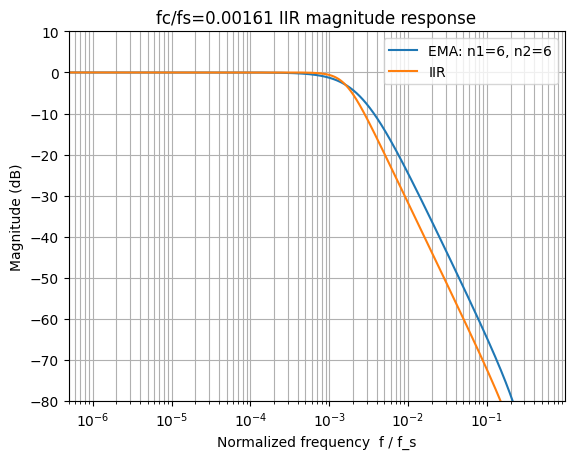

In [6]:
# 根据支持的fc/fs 列表，抽取16个fc/fs值，绘制幅频响应，并于对应fc/fs的IIR进行比较
def plot_ema_tot_iir_amp_freq(n1, n2, N=4096*128):
    w = np.linspace(0.0, math.pi, N)
    f_norm = w / (2.0 * math.pi)
    a1 = 0.5 ** n1
    a2 = 0.5 ** n2
    H1 = H_ema(a1, w)
    H2 = H_ema(a2, w)
    H_tot = H1 * H2
    plt.xscale('log')
    plt.plot(f_norm, mag_db(H_tot), label=f"EMA: n1={n1}, n2={n2}")
    plt.grid(True, which="both")
    plt.ylim(-80, 10)
    plt.xlabel("Normalized frequency  f / f_s")
    plt.ylabel("Magnitude (dB)")
    plt.title(f"Cascade EMA magnitude response, fc/fs={fc_fs_dict.get((n1, n2))}" )
    plt.legend()
    
    fc_fs_ratio = fc_fs_dict.get((n1, n2))
    b, a = butter(2, 2*fc_fs_ratio, btype='low')
    H = H_IIR(b, a, w)
    plt.xscale('log')
    plt.grid(True, which="both")
    plt.plot(f_norm, mag_db(H), label=f"IIR")
    # plt.xlim(0, 0.01)
    plt.ylim(-80, 10)
    plt.xlabel("Normalized frequency  f / f_s")
    plt.ylabel("Magnitude (dB)")
    plt.title("fc/fs={} IIR magnitude response".format(fc_fs_ratio))
    plt.legend()


# N_MIN, N_MAX = 0, 5
for n1 in n_values:
        for n2 in n_values:
            if n2 <= n1:
                fc_fs_already_plotted = set()
                if fc_fs_dict.get((n1, n2)) in fc_fs_already_plotted:
                    continue
                fc_fs_already_plotted.add(fc_fs_dict.get((n1, n2)))
                plt.figure()
                plot_ema_tot_iir_amp_freq(n1, n2)



In [7]:
t1 = np.log(0.01) / np.log(1-0.5**6)